# 1η Εργαστηριακή Άσκηση
# Μέρος 1 & 2
#Αναγνωστόπουλος Θεόδωρος 03116066
#Κορακοβούνης Δημήτριος 03116692

In [ ]:
#import libraries
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn import preprocessing

In [ ]:
#Μέρος 1: Ανίχνευση ακμών σε γκριζες εικόνες
#1.1 δημιουργία εικόνων εισόδου



Resoloution:  (512, 512)
Range: 0 - 255 


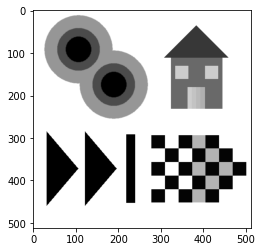

In [ ]:
#1.1.1
#read image22
img = cv2.imread('edgetest_20.png', cv2.IMREAD_GRAYSCALE)

#only for test
print("Resoloution: ", img.shape)
print("Range: %d - %d " % (img.min(), img.max()))

#normalze image
img = img.astype(np.float)/255

#show image
plt.imshow(img, cmap='gray')


Image With Noise: PSNR = 20, Standard deviation =  0.1


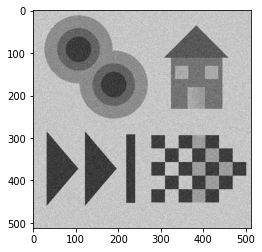

In [ ]:
#1.1.2
#image with gaussian white noise

#i)
PSNR = 20
#s1 = standard deviation
s1 = (img.max() - img.min())/(10**(PSNR/20))
gausiian_noise = np.random.normal(0,s1,img.shape)
img_noise = img + gausiian_noise
#show image
print("Image With Noise: PSNR = 20, Standard deviation = ", s1)
plt.imshow(img_noise, cmap='gray')


Image With Noise: PSNR = 20, Standard deviation =  0.31622776601683794


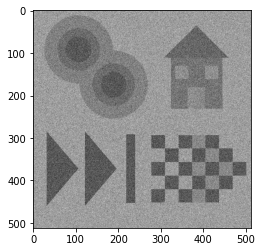

In [ ]:
#ii)
PSNR = 10
#s1 = standard deviation
s1 = (img.max() - img.min())/(10**(PSNR/20))
gausiian_noise = np.random.normal(0,s1,img.shape)
img_noise = img + gausiian_noise
#show image
print("Image With Noise: PSNR = 20, Standard deviation = ", s1)
plt.imshow(img_noise, cmap='gray')

In [ ]:
#1.2. Υλοποίηση Αλγορίθμων Ανίχνευσης Ακμών

def EdgeDetect(I, s, edge, LaplacianType): #where I = image, s = standard deviation
  #if LaplacianType = 1 -> linear
  #if LaplacianType = 2 -> non linear
  #size -> given
  #1.2.1
  n = int(np.ceil(3*s)*2 + 1)
  #Gaussian -> 1Dimenion
  gauss1d = cv2.getGaussianKernel(n,s)
  #Gaussian -> 2Dimension
  gauss2d = gauss1d @ gauss1d.T
  #LoG
  coord = np.linspace(np.ceil(-n/2),np.floor(n/2),n)
  X,Y = np.meshgrid(coord,coord)
  temp = (X ** 2 + Y ** 2) / (2 * s ** 2)
  LoG = -1 / (np.pi * s ** 4) * (1 - temp) * np.exp(-temp)
  #1.2.2
  #smooth image for Laplacian
  Ismooth = cv2.filter2D(I,-1,gauss2d)
  #definition of G ...(not sure)
  B = [[0., 1., 0.,],
        [1., 1., 1.,],
        [0., 1., 0.,]]

  if LaplacianType == 1:
    L = cv2.filter2D(I,-1,LoG)
  else:
    cv2.dilate(np.array(Ismooth),np.uint8(B))
    L = np.array(cv2.dilate(np.array(Ismooth),np.uint8(B),iterations = 1)) + np.array(cv2.erode(np.array(Ismooth),np.uint8(B),iterations = 1)) - 2*Ismooth

  #1.2.3
  #zerocrossings
  #image set to binary -- 
  Lx = len(L)
  Ly = len(L[0])
  X = np.zeros((Lx,Ly))
  thres = L.sum()/len(L)/len(L[0])
  for i in range(0,len(L)):
    for j in range(0,len(L[0])):
      if L[i][j] >= thres:
        X[i][j] = 0
      else:
        X[i][j] = 1
  
  Y = cv2.dilate(np.array(X),np.uint8(B),iterations = 1) - cv2.erode(np.array(X),np.uint8(B),iterations = 1)

  #1.2.4
  #zerocrossing with theta parameter
  grad = np.gradient(Ismooth)
  len_grad = np.empty([len(Y),len(Y[0])])
  for i in range(0,len(Y)):
    for j in range(0,len(Y[0])): 
      len_grad[i][j] = np.sqrt(grad[0][i][j]**2 + grad[1][i][j]**2)
  max_grad = len_grad.max()
  for i in range(0,len(Y)):
    for j in range(0,len(Y[0])):
      if Y[i][j] == 1 and len_grad[i][j] > max_grad*edge :
        Y[i][j] = 1
      else:
        Y[i][j] = 0
  return Y






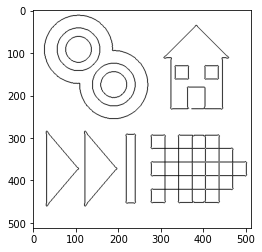

In [ ]:
res = EdgeDetect(img,2,0.2,1)
plt.imshow(res,cmap='gray_r')


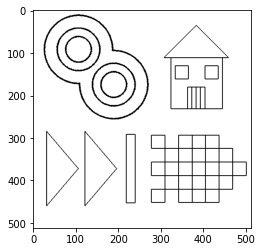

In [ ]:
#1.3.1
#real edge calculate
#θ_realedge set to 0.01
 B = [[0., 1., 0.,],
       [1., 1., 1.,],
       [0., 1., 0.,]]
M = cv2.dilate(np.array(img),np.uint8(B),iterations = 1) - cv2.erode(np.array(img),np.uint8(B),iterations = 1)
T = np.empty([len(img),len(img[0])])
for i in range(0,len(img)):
  for j in range(0,len(img[0])):
    if M[i][j] > 0.01:
      T[i][j] = 1
    else:
      T[i][j] = 0
T = T.astype(int)
plt.imshow(T,cmap='gray_r')

#tmp = EdgeDetect(img,2,0.2,2)
#plt.imshow(tmp,cmap='gray_r')

In [ ]:
#1.3.2
Recall = (res.astype(int) & T).sum() / T.sum()
Precision = (res.astype(int) & T).sum() / res.sum()
C = (Recall + Precision)/2
print(C)

0.8599237657875953


In [ ]:
#1.3.3

#Πρεπει να τρεξουμε διαφορετικες τιμες παραμετρων και PSNR
compare = []
points = np.arange(1.0, 4.0, 0.2)
theta = np.arange(0.0,0.3,0.05)
PSNR = np.arange(6,34,4)
for k in PSNR:
  bestLinear = []
  bestNonLinear = []
  for i in points:
    for j in theta:
      s1 = (img.max() - img.min())/(10**(k/20))
      gausiian_noise = np.random.normal(0,s1,img.shape)
      img_noise = img + gausiian_noise
      new1 = EdgeDetect(img_noise,i,j,1)
      new2 = EdgeDetect(img_noise,i,j,2)
      Recall = (new1.astype(int) & T).sum() / T.sum()
      Precision = (new1.astype(int) & T).sum() / new1.sum()
      C = (Recall + Precision)/2

      Recall = (new2.astype(int) & T).sum() / T.sum()
      Precision = (new2.astype(int) & T).sum() / new2.sum()
      C1 = (Recall + Precision)/2
      compare.append([i,j,C,C1])

      if(bestLinear == []):
        bestLinear.append([C,i,j])
      elif(bestLinear[0][0] < C):
        bestLinear.pop()
        bestLinear.append([C,i,j])
      if(bestNonLinear == []):
        bestNonLinear.append([C1,i,j])
      elif(bestNonLinear[0][0] < C1):
        bestNonLinear.pop()
        bestNonLinear.append([C1,i,j])
  print("Best Value For PSNR:",k)
  print('Linear:',bestLinear)
  print('Non-Linear',bestNonLinear)

      


Best Value For PSNR: 6
Linear: [[0.6263333994386973, 3.7999999999999994, 0.2]]
Non-Linear [[0.7045518514872593, 3.3999999999999995, 0.25]]
Best Value For PSNR: 10
Linear: [[0.7417815207602068, 3.1999999999999993, 0.2]]
Non-Linear [[0.8044787069099896, 2.9999999999999996, 0.2]]
Best Value For PSNR: 14
Linear: [[0.8227246654094993, 1.7999999999999998, 0.2]]
Non-Linear [[0.8569711578938506, 2.3999999999999995, 0.2]]
Best Value For PSNR: 18
Linear: [[0.8592199233297234, 1.5999999999999999, 0.15000000000000002]]
Non-Linear [[0.87721147671222, 1.9999999999999998, 0.15000000000000002]]
Best Value For PSNR: 22
Linear: [[0.8759260509087888, 1.2, 0.15000000000000002]]
Non-Linear [[0.8840598844048547, 1.5999999999999999, 0.15000000000000002]]
Best Value For PSNR: 26
Linear: [[0.8823843434799288, 1.2, 0.15000000000000002]]
Non-Linear [[0.8851164806872537, 1.4, 0.15000000000000002]]
Best Value For PSNR: 30
Linear: [[0.8845990984165973, 1.0, 0.15000000000000002]]
Non-Linear [[0.8866613923333987, 1.0

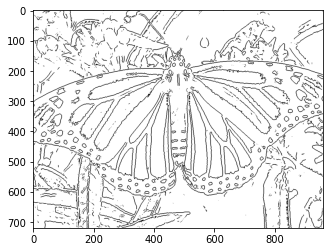

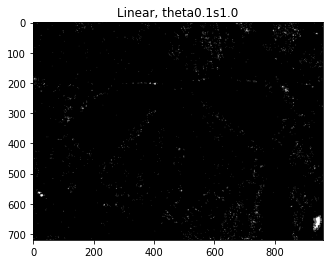

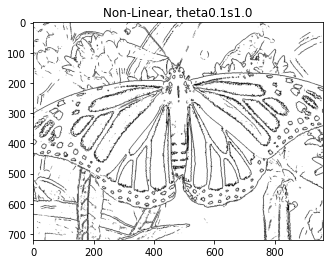

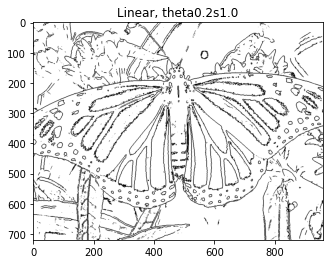

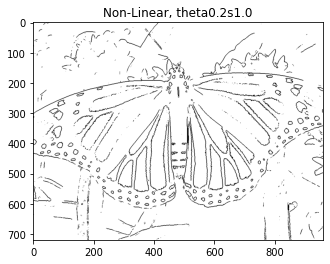

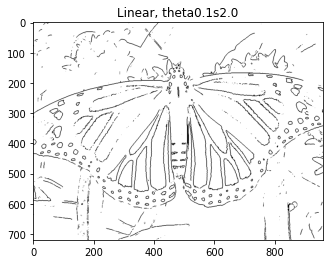

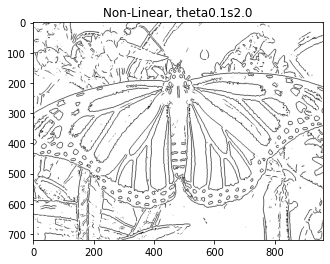

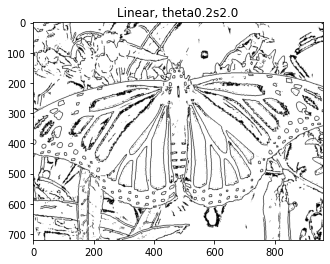

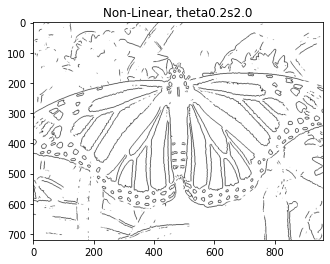

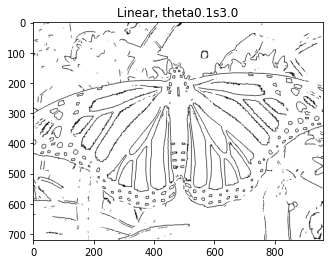

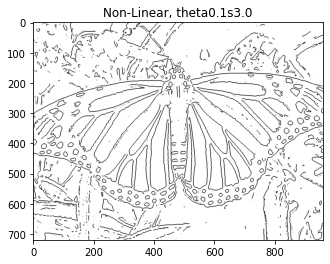

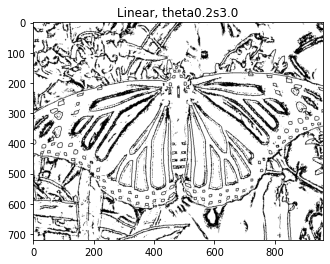

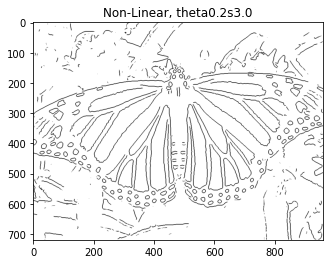

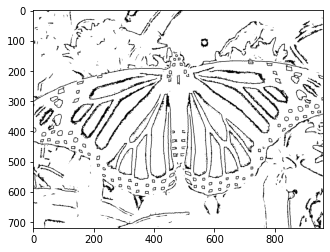

In [ ]:
#1.4
img2 = cv2.imread('butterfly.jpg', cv2.IMREAD_GRAYSCALE)
res = EdgeDetect(img2,2,0.1,1)
plt.imshow(res,cmap='gray_r')
plt.figure()


#Πρεπει να τρεξουμε διαφορετικες τιμες παραμετρων και PSNR
B = [[0., 1., 0.,],
       [1., 1., 1.,],
       [0., 1., 0.,]]
M = cv2.dilate(np.array(img2),np.uint8(B),iterations = 1) - cv2.erode(np.array(img2),np.uint8(B),iterations = 1)
T = np.empty([len(img2),len(img2[0])])
for i in range(0,len(img2)):
  for j in range(0,len(img2[0])):
    if M[i][j] > 0.01:
      T[i][j] = 1
    else:
      T[i][j] = 0
T = T.astype(int)
plt.imshow(T,cmap='gray_r')

compare = []
points = np.arange(1.0, 4.0, 1)
theta = np.arange(0.1, 0.3, 0.1)
PSNR = [1]
for k in PSNR:
  bestLinear = []
  bestNonLinear = []
  for i in points:
    for j in theta:
      s1 = (img2.max() - img2.min())/(10**(k/20))
      new1 = EdgeDetect(img2,i,j,1)
      new2 = EdgeDetect(img2,i,j,2)
      print("")
      t1="Linear, theta"+str(j)+"s"+str(i)
      plt.title(t1)
      plt.figure()
      plt.imshow(new1,cmap='gray_r')
      print("")
      t2="Non-Linear, theta"+str(j)+"s"+str(i)
      print("")
      plt.title(t2)
      plt.figure()
      plt.imshow(new2,cmap='gray_r')
      print("")


In [ ]:
##Μέρος 2: Ανίχνευση Σημείων Ενδιαφέροντος(Interest Point Detection)
#2.1

In [ ]:
#given functions needed for this part of the program
#!/usr/bin/env python

import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

def interest_points_visualization(I_, kp_data_, ax=None):
    '''
    Plot keypoints chosen by detectos on image.
    Args:
        I_: Image (if colored, make sure it is in RGB and not BGR).
        kp_data_: Nx3 array, as described in assignment.
        ax: Matplotlib axis to plot on (if None, a new Axes object is created).
    Returns:
        ax: Matplotlib axis where the image was plotted.
    '''
    try:
        I = np.array(I_)
        kp_data = np.array(kp_data_)
    except:
        print('Conversion to numpy arrays failed, check if the inputs (image and keypoints) are in the required format.')
        exit(2)

    try:
        assert(len(I.shape) == 2 or (len(I.shape) == 3 and I.shape[2] == 3))
    except AssertionError as e:
        print('interest_points_visualization: Image must be either a 2D matrix or a 3D matrix with the last dimension having size equal to 3.', file=sys.stderr)
        exit(2)

    try:
        assert(len(kp_data.shape) == 2 and kp_data.shape[1] == 3)
    except AssertionError as e:
        print('interest_points_visualization: kp_data must be a 2D matrix with 3 columns.', file=sys.stderr)
        exit(2)

    if ax is None:
        _, ax = plt.subplots()

    ax.set_aspect('equal')
    ax.imshow(I)
    ax.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)

    for i in range(len(kp_data)):
        x, y, sigma = kp_data[i]
        circ = Circle((x, y), 3*sigma, edgecolor='g', fill=False, linewidth=2)
        ax.add_patch(circ)

    return ax

def disk_strel(n):
    '''
        Return a structural element, which is a disk of radius n.
    '''
    r = int(np.round(n))
    d = 2*r+1
    x = np.arange(d) - r
    y = np.arange(d) - r
    x, y = np.meshgrid(x,y)
    strel = x**2 + y**2 <= r**2
    return strel.astype(np.uint8)

In [ ]:
def corner_finder(img,sigma,r,k,theta):
  #2.1.1
  #s,r kernel size of gaussian
  n = int(np.ceil(3*sigma)*2 + 1)
  gauss1d_s = cv2.getGaussianKernel(n,sigma)
  gauss2d_s = gauss1d_s @ gauss1d_s.T
  n = int(np.ceil(3*r)*2 + 1)
  gauss1d_r = cv2.getGaussianKernel(n,r)
  gauss2d_r = gauss1d_r @ gauss1d_r.T
  J1 = np.empty([len(img),len(img[0])])
  J2 = np.empty([len(img),len(img[0])])
  J3 = np.empty([len(img),len(img[0])])

  #Is
  filtered_img = cv2.filter2D(img,-1,gauss2d_s)
  
  #gradiant
  grad = np.gradient(filtered_img)
  partial1 = np.square(grad[0])
  partial2 = np.multiply(grad[0],grad[1])
  partial3 = np.square(grad[1])

  #J1, J2, J3
  J1 = cv2.filter2D(partial1,-1,gauss2d_r)
  J2 = cv2.filter2D(partial2,-1,gauss2d_r)
  J3 = cv2.filter2D(partial3,-1,gauss2d_r)


  #2.1.2
  #eigenvalues
  eigen_p = (J1 + J3 + np.sqrt(np.square(J1-J3) + 4*np.square(J2)))/2
  eigen_n = (J1 + J3 - np.sqrt(np.square(J1-J3) + 4*np.square(J2)))/2

  #plt.figure()
  #plt.imshow(eigen_p,cmap='gray')
  #plt.figure()
  #plt.imshow(eigen_n,cmap='gray')

  #2.1.3
  #corner criterion
  #SOS mult element by element or matrices??
  #R = eigen_p*eigen_n - k*(eigen_p+eigen_n)**2
  R = np.multiply(eigen_p, eigen_n) - k*np.square(eigen_p + eigen_n)
  #conditio 1
  B_sq = disk_strel(n)
  Cond1 = ( R==cv2.dilate(R,B_sq) )
  #condiotn 2 --> checking if R(x,y) > (θ_edge) * Rmax
  tmp = R.max()
  for i in range(len(R)):
    for j in range(len(R[0])):
      if Cond1[i][j] and R[i][j] > theta*tmp:
        Cond1[i][j] = True
      else:
        Cond1[i][j] = False
  return Cond1





In [ ]:
#set of sigma
sigma = 2

image = cv2.imread('Caravaggio2.jpg', cv2.IMREAD_COLOR)
img = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
img = img.astype(np.float)/255

tt = corner_finder(img,sigma,2.5,0.05,0.01)
#convert true-false array in the Nx3 matrix pou leei sthn ekfvnhsh
#metraw posa true yparxoun
count = 0
for i in tt:
  for j in i:
    if j:
      count +=1
#ftiaxnw ton pinaka
data = [[0 for i in range(3)]for j in range(count)]
count = 0
#pros8etw tis suntetagmenes kai to sigma
for i in range(len(tt)):
  for j in range(len(tt[0])):
    if tt[i][j]:
      data[count][0] = j
      data[count][1] = i
      data[count][2] = sigma
      count +=1
#8elei egxrwmh eikona
test = interest_points_visualization(cv2.cvtColor(image, cv2.COLOR_BGR2RGB),data)








NameError: ignored

In [ ]:


  #creation of LoG with kernel s
def LoG_kernel(s):
  n = int(np.ceil(3*s)*2 + 1)
  gauss1d = cv2.getGaussianKernel(n,s)
  gauss2d = gauss1d @ gauss1d.T

  coord = np.linspace(np.ceil(-n/2),np.floor(n/2),n)
  X,Y = np.meshgrid(coord,coord)
  temp = (X ** 2 + Y ** 2) / (2 * s ** 2)
  LoG = -1 / (np.pi * s ** 4) * (1 - temp) * np.exp(-temp)
  return LoG


  #2.2. Πολυκλιμακωτή Ανίχνευση Γωνιών
def polyclimaticEdgeFounder(img,sigma,r,k,N,s,theta):
  #2.2.1
  #pinakes gia to neo sigma kai gia to neo r
  new_sigma = np.zeros(N)
  new_r = np.zeros(N)
  #kanw ton pollaplasiasmo me to s
  for i in range(N):
    new_sigma[i] = (s**i) * sigma
    new_r[i] = (s**i) * r
  Edges = []
  for i in range(N):
    Edges.append(corner_finder(img,new_sigma[i],new_r[i],k,theta))


  filt_img = []
  for i in range(N):
    filt_img.append(cv2.filter2D(img,-1,LoG_kernel(new_sigma[i])))
  data = []
  for t in range(N):
    for i in range(len(img)):
      for k in range(len(img[0])):
        if t == 0:
          if Edges[t][i][k]:
            if filt_img[t][i][k] > filt_img[t+1][i][k]:
              data.append([k,i,new_sigma[t]])
        elif t == N-1:
          if Edges[t][i][k]:
            if filt_img[t][i][k] > filt_img[t-1][i][k]:
              data.append([k,i,new_sigma[t]])
        else:
          if Edges[t][i][k]:
            if filt_img[t][i][k] > filt_img[t-1][i][k] and filt_img[t][i][k] > filt_img[t+1][i][k]:
              data.append([k,i,new_sigma[t]])
  print(data)
  return data

   

   
  


[[1138, 137, 1.5], [1119, 148, 1.5], [1160, 155, 1.5], [825, 163, 1.5], [813, 168, 1.5], [1127, 169, 1.5], [420, 176, 1.5], [807, 179, 1.5], [823, 195, 1.5], [1137, 198, 1.5], [39, 202, 1.5], [322, 212, 1.5], [815, 218, 1.5], [297, 225, 1.5], [390, 231, 1.5], [421, 240, 1.5], [409, 243, 1.5], [477, 246, 1.5], [1133, 257, 1.5], [438, 258, 1.5], [734, 261, 1.5], [752, 269, 1.5], [477, 274, 1.5], [839, 275, 1.5], [395, 279, 1.5], [192, 282, 1.5], [26, 284, 1.5], [736, 296, 1.5], [41, 298, 1.5], [685, 307, 1.5], [681, 326, 1.5], [42, 327, 1.5], [870, 343, 1.5], [181, 345, 1.5], [1128, 350, 1.5], [671, 351, 1.5], [411, 361, 1.5], [469, 365, 1.5], [652, 366, 1.5], [408, 372, 1.5], [425, 372, 1.5], [1151, 372, 1.5], [456, 391, 1.5], [431, 399, 1.5], [171, 406, 1.5], [463, 413, 1.5], [113, 423, 1.5], [155, 424, 1.5], [306, 439, 1.5], [971, 462, 1.5], [166, 464, 1.5], [992, 464, 1.5], [1132, 465, 1.5], [318, 490, 1.5], [102, 495, 1.5], [80, 516, 1.5], [346, 517, 1.5], [7, 518, 1.5], [926, 523, 

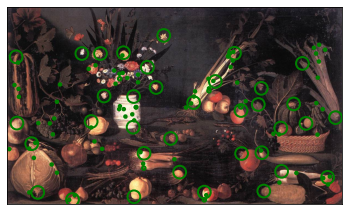

In [ ]:

test1 =cv2.imread('Caravaggio2.jpg',)
img = cv2.cvtColor(test1, cv2.COLOR_RGB2GRAY)
img = img.astype(np.float)/255
tt = polyclimaticEdgeFounder(img,1.5,1.5,0.05,10,1.2,0.005)
test = interest_points_visualization(cv2.cvtColor(test1, cv2.COLOR_BGR2RGB),tt)

In [ ]:
#2.3
def BlobsEdgeDetector(img , sigma, r, k, theta):
  #2.3.1
  n = int(np.ceil(3*sigma)*2 + 1)
  gauss1d_s = cv2.getGaussianKernel(n,sigma)
  gauss2d_s = gauss1d_s @ gauss1d_s.T
  n = int(np.ceil(3*r)*2 + 1)
  gauss1d_r = cv2.getGaussianKernel(n,r)
  gauss2d_r = gauss1d_r @ gauss1d_r.T
  #Is
  filtered_img = cv2.filter2D(img,-1,gauss2d_s)
  #gradiant
  grad = np.gradient(filtered_img) #first 
  #2h paragwgos
  Lxx = np.gradient(grad[0])[0]
  Lyy = np.gradient(grad[1])[1]
  Lxy = np.gradient(grad[0])[1]
  rows = len(Lxx)
  col = len(Lxx[0])
  #R = det(H)
  #dn ftiaxnw ton H, kanw kateu8eian det kai ftiaxnw ton R
  R = [[0 for j in range(col)] for i in range(rows)]
  for i in range(rows):
    for j in range(col):
      R[i][j] = Lxx[i][j]*Lyy[i][j] - Lxy[i][j]*Lxy[i][j]                   
  #2.3.2
  #condition 1 opws corner_finder
  B_sq = disk_strel(n)
  Cond1 = ( R==cv2.dilate(np.array(R),B_sq) )
  #condition 2 opws corner_finder
  tmp = (np.array(R)).max()
  for i in range(len(R)):
    for j in range(len(R[0])):
      if Cond1[i][j] and R[i][j] > theta*tmp:
        Cond1[i][j] = True
      else:
        Cond1[i][j] = False
  return Cond1
  




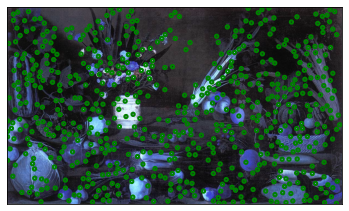

In [ ]:
tt = BlobsEdgeDetector(img,2,2.5,0.05,0.01)
#ftiaxv pinaka Nx3 opws 8elei
count = 0
for i in tt:
  for j in i:
    if j:
      count +=1

data = [[0 for i in range(3)]for j in range(count)]
count = 0
for i in range(len(tt)):
  for j in range(len(tt[0])):
    if tt[i][j]:
      data[count][0] = j
      data[count][1] = i
      data[count][2] = 2
      count +=1
test1 =cv2.imread('Caravaggio2.jpg')
test = interest_points_visualization(test1,data)


In [ ]:
#2.4. Πολυκλιμακωτή Ανίχνευση Blobs
def polyclimaticBlobsEdgeFounder(img,sigma,r,k,N,s,theta):
  #2.2.1
  new_sigma = np.zeros(N)
  new_r = np.zeros(N)
  for i in range(N):
    new_sigma[i] = (s**i) * sigma
    new_r[i] = (s**i) * r
  #use previous function for every new_sigma and new_r
  Edges = []
  for i in range(N):
    Edges.append(BlobsEdgeDetector(img,new_sigma[i],new_r[i],k,theta))
  
  #2.2.2
  filt_img = []
  for i in range(N):
    filt_img.append(cv2.filter2D(img,-1,LoG_kernel(new_sigma[i])))
  data = []
  for t in range(N):
    for i in range(len(img)):
      for k in range(len(img[0])):
        if t == 0:
          if Edges[t][i][k]:
            if filt_img[t][i][k] > filt_img[t+1][i][k]:
              data.append([k,i,new_sigma[t]])
        elif t == N-1:
          if Edges[t][i][k]:
            if filt_img[t][i][k] > filt_img[t-1][i][k]:
              data.append([k,i,new_sigma[t]])
        else:
          if Edges[t][i][k]:
            if filt_img[t][i][k] > filt_img[t-1][i][k] and filt_img[t][i][k] > filt_img[t+1][i][k]:
              data.append([k,i,new_sigma[t]])
  print(data)
  return data

[[806, 179, 2.0], [823, 195, 2.0], [322, 211, 2.0], [816, 218, 2.0], [753, 268, 2.0], [395, 280, 2.0], [686, 303, 2.0], [736, 305, 2.0], [795, 367, 2.0], [424, 372, 2.0], [458, 392, 2.0], [432, 399, 2.0], [1102, 401, 2.0], [991, 463, 2.0], [486, 529, 2.0], [1152, 624, 2.0], [81, 676, 2.0], [719, 703, 2.0], [225, 704, 2.0], [570, 104, 6.75], [424, 166, 6.75], [273, 168, 6.75], [340, 169, 6.75], [32, 180, 6.75], [1076, 204, 6.75], [510, 219, 6.75], [759, 270, 6.75], [927, 295, 6.75], [353, 322, 6.75], [461, 326, 6.75], [680, 348, 6.75], [1044, 353, 6.75], [1198, 403, 6.75], [305, 416, 6.75], [34, 423, 6.75], [1090, 424, 6.75], [459, 438, 6.75], [997, 442, 6.75], [597, 480, 6.75], [929, 532, 6.75], [498, 533, 6.75], [855, 534, 6.75], [1001, 599, 6.75], [628, 601, 6.75], [1167, 620, 6.75], [935, 671, 6.75], [718, 675, 6.75], [111, 676, 6.75], [462, 692, 6.75], [238, 701, 6.75]]


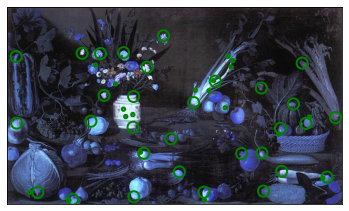

In [ ]:
tt = polyclimaticEdgeFounder(img,2,2.5,0.05,4,1.5,0.01)
test1 =cv2.imread('Caravaggio2.jpg')
test = interest_points_visualization(test1,tt)

In [ ]:
#2.5
sigma = 2.0
theta = 0.05
#2.5.1


tim = np.zeros((len(img)+1,len(img[1])+1))
for x in range(len(img)):
  for y in range(len(img[1])):
    tim[x+1][y+1] = img[x][y] + tim[x][y+1] + tim[x+1][y] - tim[x][y]
integ_img = tim[1:,1:]


#2.5.2

n = 2*np.ceil(3*sigma) + 1
n = int(n)
#Dxx: size
Dxx_rows = int(4*np.floor(n/6) + 1)
Dxx_col = int(2*np.floor(n/6) + 1)
#Dyy: size
Dyy_rows = int(2*np.floor(n/6) + 1)
Dyy_col = int(4*np.floor(n/6) + 1)
#Dxy: size
Dxy_rows = int(2*np.floor(n/6) + 1)
Dxy_col = int(2*np.floor(n/6) + 1)


ttt = np.zeros((len(integ_img)+n-1,len(integ_img[1])+n-1))
for x in range(0,len(integ_img)):
  for y in range(0,len(integ_img[0])):
    ttt[n//2+x, n//2+y] = img[x][y]

tim = np.zeros((len(ttt)+1,len(ttt[1])+1))
for x in range(len(ttt)):
  for y in range(len(ttt[1])):
    tim[x+1][y+1] = ttt[x][y] + tim[x][y+1] + tim[x+1][y] - tim[x][y]
ttt = tim[1:,1:]

#ROWS -- BIG
#COL -- SMALL

ch1 = Dxx_rows//2
ch2 = (Dxx_col*3)//2
ch3 = Dxx_col//2-1
ch4 = Dxx_col//2
ch5 = Dxx_col//2+1
if type(sigma) == 'int':
  ch5 = Dxx_col//2
nn = n//2

Lxx = np.zeros((len(integ_img),len(integ_img[0])))
for x in range(0,len(integ_img)):
  for y in range(0,len(integ_img[0])):
    xx = nn + x
    yy = nn + y
    left = ttt[xx-ch1][yy-ch2] + ttt[xx+ch1][yy-ch3] - ttt[xx-ch1][yy-ch3] - ttt[xx+ch1][yy-ch2]
    center = -2*(ttt[xx-ch1][yy-ch4] + ttt[xx+ch1][yy+ch4] - ttt[xx-ch1][yy+ch4] - ttt[xx+ch1][yy-ch4])
    right = -ttt[xx-ch1][yy+ch2] - ttt[xx+ch1][yy+ch5] + ttt[xx-ch1][yy+ch5] + ttt[xx+ch1][yy+ch2]
    Lxx[x][y] = left + right + center

Lyy = np.zeros((len(integ_img),len(integ_img[0])))
for x in range(0,len(integ_img)):
  for y in range(0,len(integ_img[0])):
    xx = nn + x
    yy = nn + y
    up = ttt[xx-ch2][yy-ch1] + ttt[xx-ch3][yy+ch1] - ttt[xx-ch3][yy-ch1] - ttt[xx-ch2][yy+ch1]
    center = -2*(ttt[xx-ch4][yy-ch1] + ttt[xx+ch4][yy+ch1] - ttt[xx+ch4][yy-ch1] - ttt[xx-ch4][yy+ch1])
    down = -ttt[xx+ch2][yy-ch1] - ttt[xx+ch5][yy+ch1] + ttt[xx+ch5][yy-ch1] + ttt[xx+ch2][yy+ch1]
    Lyy[x][y] = left + right + center

val = Dxy_col
Lxy = np.zeros((len(integ_img),len(integ_img[0])))
for x in range(0,len(integ_img)):
  for y in range(0,len(integ_img[0])):
    xx = nn + x
    yy = nn + y
    lu = ttt[xx-val][yy-val] + ttt[xx-1][yy-1] - ttt[xx-val][yy-1] - ttt[xx-1][yy-val]
    ru = -(ttt[xx-val][yy+1] + ttt[xx-1][yy+val] - ttt[xx-1][yy+1] - ttt[xx-val][yy+val])
    ld = -(ttt[xx+val][yy-1] + ttt[xx+1][yy-val] - ttt[xx+val][yy-val] - ttt[xx+1][yy-1])
    rd = ttt[xx+1][yy+1] + ttt[xx+val][yy+val] - ttt[xx+val][yy+1] - ttt[xx+1][yy+val]
    Lxy[x][y] = lu + ru + ld + rd

#2.5.3
R = np.multiply(Lxx,Lyy) - np.multiply(0.9*Lxy,0.9*Lxy)
#condition 1 opws corner_finder
B_sq = disk_strel(n)
Cond1 = ( R==cv2.dilate(np.array(R),B_sq) )
#condition 2 opws corner_finder
tmp = (np.array(R)).max()
for i in range(len(R)):
  for j in range(len(R[0])):
    if Cond1[i][j] and R[i][j] > theta*tmp:
      Cond1[i][j] = True
    else:
      Cond1[i][j] = False
tt = Cond1
#ftiaxv pinaka Nx3 opws 8elei
count = 0
for i in tt:
  for j in i:
    if j:
      count +=1

data = [[0 for i in range(3)]for j in range(count)]
count = 0
for i in range(len(tt)):
  for j in range(len(tt[0])):
    if tt[i][j]:
      data[count][0] = j
      data[count][1] = i
      data[count][2] = sigma
      count +=1
test1 =cv2.imread('Caravaggio2.jpg')
img = cv2.cvtColor(test1, cv2.COLOR_RGB2GRAY)
test1 = cv2.cvtColor(test1, cv2.COLOR_RGB2BGR)
img = img.astype(np.float)/255
test1 = test1.astype(np.float)/255
test = interest_points_visualization(test1,data)

#2.5.5
s = 1.5
N = 4
new_sigma = np.zeros(N)
Edges = []
#kanw ton pollaplasiasmo me to s
for i in range(N):
  new_sigma[i] = (s**i) * sigma

filt_img = []
for k in new_sigma:
  n = 2*np.ceil(3*k) + 1
  n = int(n)
  #Dxx: size
  Dxx_rows = int(4*np.floor(n/6) + 1)
  Dxx_col = int(2*np.floor(n/6) + 1)
  #Dyy: size
  Dyy_rows = int(2*np.floor(n/6) + 1)
  Dyy_col = int(4*np.floor(n/6) + 1)
  #Dxy: size
  Dxy_rows = int(2*np.floor(n/6) + 1)
  Dxy_col = int(2*np.floor(n/6) + 1)


  ttt = np.zeros((len(integ_img)+n-1,len(integ_img[1])+n-1))
  for x in range(0,len(integ_img)):
    for y in range(0,len(integ_img[0])):
      ttt[n//2+x, n//2+y] = integ_img[x][y]

  tim = np.zeros((len(ttt)+1,len(ttt[1])+1))
  for x in range(len(ttt)):
    for y in range(len(ttt[1])):
      tim[x+1][y+1] = ttt[x][y] + tim[x][y+1] + tim[x+1][y] - tim[x][y]
  ttt = tim[1:,1:]
  
  #ROWS -- BIG
  #COL -- SMALL


  Lxx = np.zeros((len(integ_img),len(integ_img[0])))
  for x in range(0,len(integ_img)):
    for y in range(0,len(integ_img[0])):
      xx = nn + x
      yy = nn + y
      left = ttt[xx-ch1][yy-ch2] + ttt[xx+ch1][yy-ch3] - ttt[xx-ch1][yy-ch3] - ttt[xx+ch1][yy-ch2]
      center = -2*(ttt[xx-ch1][yy-ch4] + ttt[xx+ch1][yy+ch4] - ttt[xx-ch1][yy+ch4] - ttt[xx+ch1][yy-ch4])
      right = -ttt[xx-ch1][yy+ch2] - ttt[xx+ch1][yy+ch5] + ttt[xx-ch1][yy+ch5] + ttt[xx+ch1][yy+ch2]
      Lxx[x][y] = left + right + center

  Lyy = np.zeros((len(integ_img),len(integ_img[0])))
  for x in range(0,len(integ_img)):
    for y in range(0,len(integ_img[0])):
      xx = nn + x
      yy = nn + y
      up = ttt[xx-ch2][yy-ch1] + ttt[xx-ch3][yy+ch1] - ttt[xx-ch3][yy-ch1] - ttt[xx-ch2][yy+ch1]
      center = -2*(ttt[xx-ch4][yy-ch1] + ttt[xx+ch4][yy+ch1] - ttt[xx+ch4][yy-ch1] - ttt[xx-ch4][yy+ch1])
      down = -ttt[xx+ch2][yy-ch1] - ttt[xx+ch5][yy+ch1] + ttt[xx+ch5][yy-ch1] + ttt[xx+ch2][yy+ch1]
      Lyy[x][y] = left + right + center

  val = Dxy_col
  Lxy = np.zeros((len(integ_img),len(integ_img[0])))
  for x in range(0,len(integ_img)):
    for y in range(0,len(integ_img[0])):
      xx = nn + x
      yy = nn + y
      lu = ttt[xx-val][yy-val] + ttt[xx-1][yy-1] - ttt[xx-val][yy-1] - ttt[xx-1][yy-val]
      ru = -(ttt[xx-val][yy+1] + ttt[xx-1][yy+val] - ttt[xx-1][yy+1] - ttt[xx-val][yy+val])
      ld = -(ttt[xx+val][yy-1] + ttt[xx+1][yy-val] - ttt[xx+val][yy-val] - ttt[xx+1][yy-1])
      rd = ttt[xx+1][yy+1] + ttt[xx+val][yy+val] - ttt[xx+val][yy+1] - ttt[xx+1][yy+val]
      Lxy[x][y] = lu + ru + ld + rd


  #2.5.3
  R = np.multiply(Lxx,Lyy) - np.multiply(0.9*Lxy,0.9*Lxy)
  #condition 1 opws corner_finder
  B_sq = disk_strel(n)
  Cond1 = ( R==cv2.dilate(np.array(R),B_sq) )
  #condition 2 opws corner_finder
  tmp = (np.array(R)).max()
  for i in range(len(R)):
    for j in range(len(R[0])):
      if Cond1[i][j] and R[i][j] > theta*tmp:
        Cond1[i][j] = True
      else:
        Cond1[i][j] = False
  Edges.append(Cond1)
  
  filt_img.append(cv2.filter2D(img,-1,LoG_kernel(k)))
for t in range(N):
  for i in range(len(img)):
    for k in range(len(img[0])):
      if t == 0:
        if Edges[t][i][k]:
          if filt_img[t][i][k] > filt_img[t+1][i][k]:
            data.append([k,i,new_sigma[t]])
      elif t == N-1:
        if Edges[t][i][k]:
          if filt_img[t][i][k] > filt_img[t-1][i][k]:
              data.append([k,i,new_sigma[t]])
      else:
        if Edges[t][i][k]:
          if filt_img[t][i][k] > filt_img[t-1][i][k] and filt_img[t][i][k] > filt_img[t+1][i][k]:
             data.append([k,i,new_sigma[t]])



test1 =cv2.imread('Caravaggio2.jpg')
img = cv2.cvtColor(test1, cv2.COLOR_RGB2GRAY)
test1 = cv2.cvtColor(test1, cv2.COLOR_RGB2BGR)
img = img.astype(np.float)/255
test1 = test1.astype(np.float)/255
test = interest_points_visualization(test1,data)


IndexError: ignored

In [ ]:
#Μέρος 3: Εφαρμογές σε Ταίριασμα και Κατηγοριοποίηση Εικόνων με
#Χρήση Τοπικών Περιγραφητών στα Σημεία Ενδιαφέροντος
import cv20_lab1_part31_utils as p3

